# Simulate single cell nanopore reads

In [27]:
# load 10x barcode whitelist
whole_whitelist = []
with open("../data/3M-february-2018.txt", 'r') as f:
    for line in f:
        whole_whitelist.append(line.strip())
whole_whitelist = set(whole_whitelist)

# Use BC information from short reads (by Cellranger)'

# Cellranger output
filtered_matrix_h5 = "../data/hiPSC_diff/cellranger/filtered_feature_bc_matrix.h5"
raw_matrix_h5 = "../data/hiPSC_diff/cellranger/raw_feature_bc_matrix.h5"

cr_filtered_bc = set(filtered_feature_bc_matrix.get_barcode_str())
cr_count_d = pd.DataFrame({
    "BC": raw_feature_bc_matrix.get_barcode_str(),
    "counts": raw_feature_bc_matrix.get_barcode_umi_count()
})
cr_count_d['is_cell'] = cr_count_d.BC.isin(cr_filtered_bc)
cr_count_d = cr_count_d.sort_values(by=['counts'], ascending = False).reset_index()
cr_count_d = cr_count_d[cr_count_d.counts > 0]

In [29]:
# save the UMI count per BC from short read
cr_count_d.to_csv('../data/SR_bc.csv',header=True)

## Running the simulation
The following code was run on ternimal:

### generate perfect reads
```bash
PERFECT_READ=/data/projects/punim0614/yupei/project/SC_demultiplex_proj/simulation/perfect_read/1000cell_perfect_read.fa

python3 ~/github_repo/youyupei/sc_long_read_sim/bin/perfect_read_generator.py -o $PERFECT_READ -i ~/github_repo/youyupei/sc_long_read_sim/data/1000_simulated_cell_umi.csv --thread 32 -r 
```

### introduce nanopore error
```bash
cd /data/projects/punim0614/yupei/project/SC_demultiplex_proj/simulation/SLsim_sample
python3 ~/github_repo/youyupei/sc_long_read_sim/bin/error_simulator.py --thread 32 --badread-identity 94,1.35,100 -o 94_1.35_100_ideal.fq -t ../perfect_read/1000cell_perfect_read.fa --badread-qscore-model ideal --batch-size 5000
```
**NOTE:**
The read accruacy distribution is close to what we have observed in real data. We used ideal qscore model from badread because the other models didn't give us realistic distribution of the q score. Although the "ideal qscore" model was also not the best, it did show different distribution between the minimum Qscores of error-free putative barcodes and those from error-containing putative barcodes (This is what we have observed in the real data).

**Command line output:** 
```
Loading error model from /home/youyupei/.conda/envs/blaze/lib/python3.7/site-packages/badread/error_models/nanopore2020.gz
  done: loaded error distributions for 16384 7-mers

Using an ideal qscore model

Generating read identities from a beta distribution:
  mean  =  94%      shape parameters:
  max   = 100%        alpha = 2.8996e+02
  stdev = 1.4%        beta  = 1.8508e+01
  │                                            ▌     
  │                                           ▌▌     
  │                                           ▌▌     
  │                                           ▌▌▌    
  │                                          ▌▌▌▌    
  │                                          ▌▌▌▌    
  │                                         ▖▌▌▌▌    
  │                                        ▖▌▌▌▌▌▌   
  ├─────────┬─────────┬─────────┬─────────┬─────────┐
  50        60        70        80        90        100
  


```

### run blaze 
```bash
python3 ~/github_repo/shimlab/BLAZE/bin/blaze.py --expect-cell 1000 --threads 32 template.fa

```
  
### run sockeye
```
  snakemake --use-conda  --core all -pr all
```

# Simulation data analysis

In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
from matplotlib import pyplot as plt
import collections
import upsetplot

import analysis_functions as af

In [2]:
# config filename:
# Cellranger output
filtered_matrix_h5 = "../data/hiPSC_diff/cellranger/filtered_feature_bc_matrix.h5"
raw_matrix_h5 = "../data/hiPSC_diff/cellranger/raw_feature_bc_matrix.h5"

# BLAZE output
blaze_raw_bc_fn = '../data/simulation/blaze/putative_bc.csv'

# sockeye
sock_whitelist = '../data/simulation/sockeye/whitelist.tsv'
sock_count = '../data/simulation/sockeye/uncorrected_bc_counts.tsv'

# output
out_dir = '../data/simulation/'

In [3]:
def reverse_complement(seq):
    '''
    Args: <str>
        queried seq
    Returns: <str>
        reverse_complement seq
    '''
    comp = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 
                    'a': 't', 'c': 'g', 'g': 'c', 't': 'a'}
    letters = \
        [comp[base] if base in comp.keys() else base for base in seq]
    return ''.join(letters)[::-1]

## Prepare ground truth

**Note**: In this analysis the ground truth is exactly the cell ranger result. Because all the simulation is based on the short reads barcodes and their frequencies.

In [4]:
# get cell ranger matrix
class cr_matrix:
    def __init__(self, mat_file):
        self.mat = af.get_matrix_from_h5(mat_file)
    
    def get_barcode_umi_count(self):
        '''
        Get the barcode umi count (columns sum) of the matrix
        return:
            np.array
        '''
        return np.array(self.mat.matrix.sum(0)).reshape(-1)
    def get_barcode_str(self, as_str = True):
        '''
        get the barcode stored in the matrix.hs
        
        Option:
            as_str: <bool> whether convert the barcode to str (True by default)
        return:
            np.array of barcodes
        '''
        if as_str:
            return np.array([x.decode('UTF-8').split('-')[0] for x in self.mat.barcodes])
        else:
            return self.mat.barcodes


filtered_feature_bc_matrix = cr_matrix(filtered_matrix_h5)
raw_feature_bc_matrix = cr_matrix(raw_matrix_h5)

In [5]:
cr_filtered_bc = set(filtered_feature_bc_matrix.get_barcode_str())
cr_count_d = pd.DataFrame({
    "BC": raw_feature_bc_matrix.get_barcode_str(),
    "counts": raw_feature_bc_matrix.get_barcode_umi_count()
})



In [6]:
cr_count_d['is_cell'] = cr_count_d.BC.isin(cr_filtered_bc)
cr_count_d = cr_count_d.sort_values(by=['counts'], ascending = False).reset_index()

## BLAZE

In [7]:
# load BLAZE result and correctness of putative barcode

# blaze raw bc table
putative_bc_d = pd.read_csv(blaze_raw_bc_fn)
# add ground truth
putative_bc_d['true_BC'] = putative_bc_d.read_id.apply(lambda x: x.split('_')[0])
putative_bc_d['BC_correctness'] = putative_bc_d.putative_bc == putative_bc_d.true_BC

In [57]:
# Summary
print(f"""
Putative barcode accruacy: {putative_bc_d.BC_correctness.mean()*100:.2f}%

Proportion of putative barcodes with minQ >= 15: {np.mean(putative_bc_d.putative_bc_min_q>=15)*100:.2f}% 
Accuracy of putative barcodes with minQ >= 15: {putative_bc_d[putative_bc_d.putative_bc_min_q>=15].BC_correctness.mean()*100:.2f}%

Proportion of putative barcodes with minQ >= 7: {np.mean(putative_bc_d.putative_bc_min_q>=7)*100:.2f}% 
Accuracy of putative barcodes with minQ >= 7: {putative_bc_d[putative_bc_d.putative_bc_min_q>=7].BC_correctness.mean()*100:.2f}%
""")


Putative barcode accruacy: 38.60%

Proportion of putative barcodes with minQ >= 15: 38.69% 
Accuracy of putative barcodes with minQ >= 15: 88.31%

Proportion of putative barcodes with minQ >= 7: 42.20% 
Accuracy of putative barcodes with minQ >= 7: 85.27%



### Generate the whitelist

The default minQ threshold 15 for real data. However, the 15 seems not to be a realitic value for this simulted data. I use try 7.

In [10]:
# threshold for minQ
def tune_minQ(minQ, d):
    raw_bc_d_HQ = d[d.putative_bc_min_q >= minQ].putative_bc.value_counts().to_frame()
    raw_bc_d_HQ['bc_rank'] = list(range(1,len(raw_bc_d_HQ)+1))
    raw_bc_d_HQ.reset_index(inplace=True)
    raw_bc_d_HQ = raw_bc_d_HQ.rename(columns = {'index':'BC', 'raw_bc':'counts'})
    rst_d = raw_bc_d_HQ[raw_bc_d_HQ.BC.isin(whole_whitelist)]
    rst_d.reset_index(inplace=True)
    return rst_d

# use default threshold 15 
putative_bc_d_minQ15_filtered = tune_minQ(15, d = putative_bc_d)

#### Threshod of count Quantile
Applying count threshold manually 
* Default: 95-percentile of top N cell / 20
* High sensitivity (HS) mode: 95-percentile of top N cell / 200

In [11]:
# Threshold
# Default threshod of count Quantile (95-percentile of top N cell / 20)
def percentile_count_thres(count_array, exp_cells=None):
    if exp_cells:
        top_count = np.sort(count_array)[::-1][:exp_cells]
        return np.quantile(top_count, 0.95)/20
    else:
        exp_cells = 0
        new_exp_cells = int(len(count_array)/2)
        count_array = np.sort(count_array)[::-1]
        while exp_cells != new_exp_cells:  
            exp_cells = new_exp_cells
            
            top_count = count_array[:exp_cells]
            t = np.quantile(top_count, 0.95)/20

            new_exp_cells = (count_array >= t).sum()
            print(exp_cells,new_exp_cells, t)
        return t

threshold = percentile_count_thres(putative_bc_d_minQ15_filtered.putative_bc,500)

# high_sensitivity threshold
def percentile_count_thres_high_sensitivity(count_array, exp_cells=None):
    if exp_cells:
        top_count = np.sort(count_array)[::-1][:exp_cells]
        return np.quantile(top_count, 0.95)/200
    else:
        exp_cells = 0
        new_exp_cells = int(len(count_array)/2)
        count_array = np.sort(count_array)[::-1]
        while exp_cells != new_exp_cells:  
            exp_cells = new_exp_cells
            
            top_count = count_array[:exp_cells]
            t = np.quantile(top_count, 0.95)/200

            new_exp_cells = (count_array >= t).sum()
            print(exp_cells,new_exp_cells, t)
        return t

threshold_high_sen = percentile_count_thres_high_sensitivity(putative_bc_d_minQ15_filtered.putative_bc,500)

The expected number of cell is set to 500 but the result is not sensitive to the number:

## Sockeye

### Loading sockeye whitelist and check the agreement

In [15]:
# load sockeye whitelist
sock_whitelist = set(pd.read_csv(sock_whitelist, header = None)[0])

# sockeye raw count
sock_count = pd.read_csv(sock_count, header = None, sep = '\t', names = ['BC', 'counts'])

# sort the count
sock_count = sock_count.sort_values(by=['counts'], ascending = False)

## PRC plot

In [24]:
from sklearn.metrics import precision_recall_curve

missing_bc =  [1]* len(cr_filtered_bc - set(putative_bc_d_minQ15_filtered.BC))
missing_bc_count = [0] * len(missing_bc)
blaze_pre,blaze_recall , blaze_thresholds =\
                            precision_recall_curve([int(x in cr_filtered_bc) for x in putative_bc_d_minQ15_filtered.BC] + missing_bc,
                                                   list(putative_bc_d_minQ15_filtered.putative_bc) + missing_bc_count)



missing_bc =  [1]* len(cr_filtered_bc - set(sock_count.BC))
missing_bc = [1] * len(missing_bc)
missing_bc_count = [0] * len(missing_bc)
sockeye_pre,sockeye_recall , sockeye_thresholds =\
                            precision_recall_curve([int(x in cr_filtered_bc) for x in sock_count.BC] + missing_bc,
                                                   list(sock_count.counts)+missing_bc_count)


/tmp/ipykernel_13238/3493766576.py:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([blz_re], [blz_p],'o',  color='c',markersize=6, label='BLAZE default threshold', marker = 'x' )
/tmp/ipykernel_13238/3493766576.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([sock_re], [sock_p],'o',   color='orange',markersize=6, label='Sockeye default threshold', marker = 'x' )
/tmp/ipykernel_13238/3493766576.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([blz_hi_re], [blz_hi_p], 'o', color='c', markersize=6, label='BLAZE HS mode' , marker = '^' )


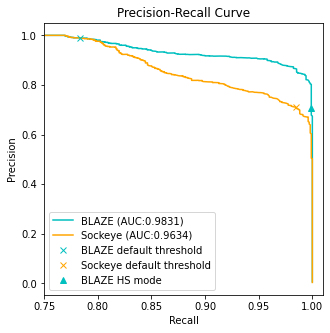

In [55]:
from sklearn.metrics import auc
#create precision recall curve

sock_p  = len(cr_filtered_bc&sock_whitelist)/len(sock_whitelist)
sock_re = len(cr_filtered_bc&sock_whitelist)/len(cr_filtered_bc)
blz_p = len(cr_filtered_bc&passed_bc)/len(passed_bc)
blz_re = len(cr_filtered_bc&passed_bc)/len(cr_filtered_bc)
blz_hi_p = len(cr_filtered_bc&passed_bc_hs)/len(passed_bc_hs)
blz_hi_re = len(cr_filtered_bc&passed_bc_hs)/len(cr_filtered_bc)


fig, ax = plt.subplots(figsize = (5,5))
ax.plot(blaze_recall, blaze_pre, 
        label = f'BLAZE (AUC:{auc(blaze_recall,blaze_pre):.4f})', color='c')

ax.plot(sockeye_recall, sockeye_pre, 
        label = f'Sockeye (AUC:{auc(sockeye_recall, sockeye_pre):.4f})', color='orange')


ax.plot([blz_re], [blz_p],'o',  color='c',markersize=6, label='BLAZE default threshold', marker = 'x' )
ax.plot([sock_re], [sock_p],'o',   color='orange',markersize=6, label='Sockeye default threshold', marker = 'x' )
ax.plot([blz_hi_re], [blz_hi_p], 'o', color='c', markersize=6, label='BLAZE HS mode' , marker = '^' )
ax.legend()
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_xlim(0.75,1.01)




#display plot
plt.savefig('sim_zoomin.svg', format='svg')
plt.show()